In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 


In [4]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)

CPU times: user 740 ms, sys: 5.14 s, total: 5.88 s
Wall time: 5.93 s


In [5]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [6]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [7]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

In [8]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

In [9]:
%%time
# randomly split cells into train (lowdim, highdim) and test (lowdim, highdim to be predicted)
X = ref_data.X.copy()
y = np.array(ref_data_genes.X.todense()).copy()

X = basicu.zscore(X, axis=0)
y = np.log10(y+1)
# y.data = np.log10(y.data+1)

print(X.shape, y.shape)

(73347, 24) (73347, 5576)
CPU times: user 7.67 s, sys: 23.4 s, total: 31.1 s
Wall time: 31.2 s


In [85]:
%%time
np.random.seed(0)
n_splits = 2
n_k = 5

kf = KFold(n_splits=n_splits, shuffle=True)
for train_idx, test_idx in kf.split(X):
    X_train = X[train_idx, :]
    X_test = X[test_idx, :]
    y_train = y[train_idx, :]
    y_test = y[test_idx, :]

    model = NearestNeighbors(n_neighbors=n_k, metric='euclidean', algorithm='ball_tree')
    model.fit(X_train)
    # test (row) by train (col)
    knn = model.kneighbors_graph(X_test)
    y_pred = knn.dot(y_train)/n_k
    
    # eval
    mse = np.power(y_test-y_pred, 2).mean()
    r2 = 1-(mse/np.power(y_test-np.mean(y_test, axis=0), 2).mean())
    print(mse, r2)

    break


0.33296903779015535 0.1370157362277783
CPU times: user 50.1 s, sys: 32.8 s, total: 1min 22s
Wall time: 1min 23s


In [84]:
# 1 - np.power(y_pred-y_test, 2).sum()/np.power(y_test,2).sum()
1 - np.linalg.norm(y_test-y_pred)**2/np.linalg.norm(y_test-np.mean(y_test, axis=0))**2

0.13685720354781372

In [11]:
%%time
corr_cell = basicu.corr_paired_rows_fast(y_pred, y_test)
corr_gene = basicu.corr_paired_rows_fast(y_pred.T, y_test.T)
print(corr_cell.shape, corr_gene.shape)

/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/basicu.py:52: RuntimeWarning:

invalid value encountered in true_divide

/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/basicu.py:53: RuntimeWarning:

invalid value encountered in true_divide



(36674,) (5576,)
CPU times: user 10.7 s, sys: 1min 35s, total: 1min 45s
Wall time: 1min 46s


In [12]:
corr_cell = np.nan_to_num(corr_cell, 0)
corr_gene = np.nan_to_num(corr_gene, 0)

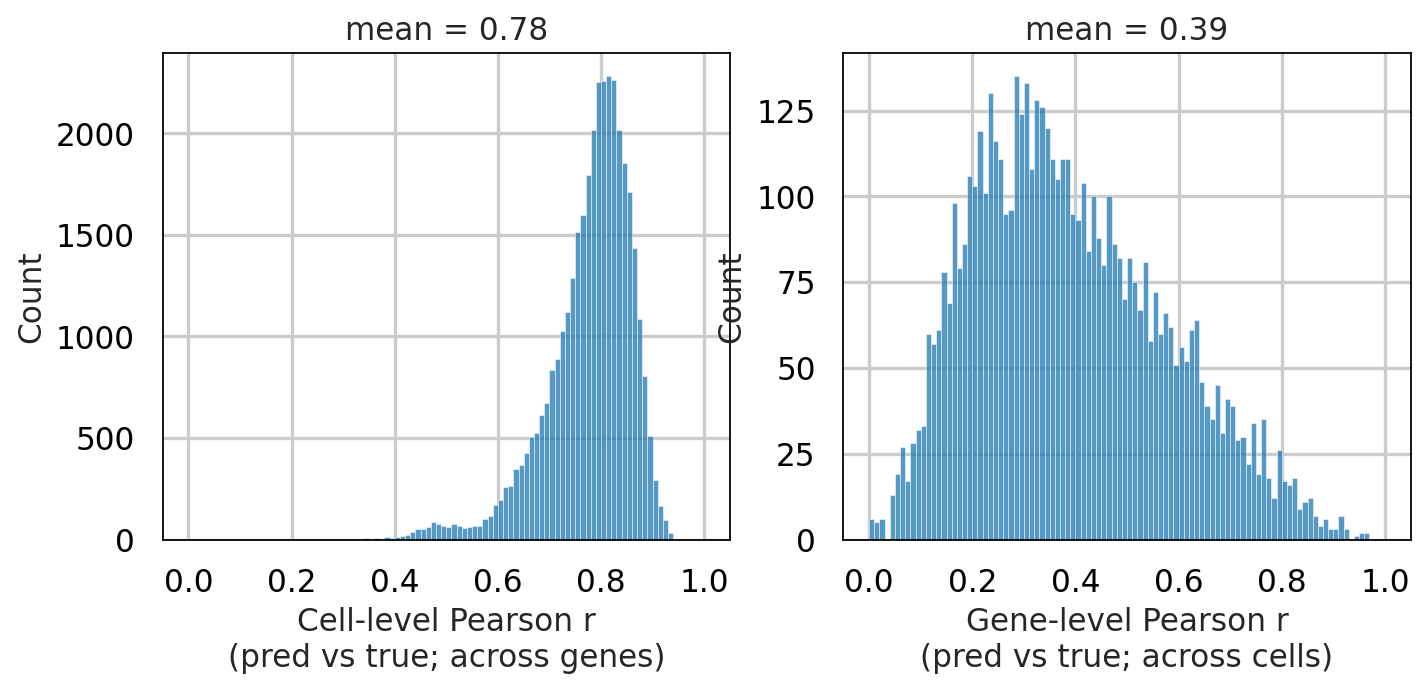

In [13]:
bins = np.linspace(0, 1, 101)
fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
ax = axs[0]
sns.histplot(corr_cell, bins=bins, ax=ax)
corr_meancell = np.mean(corr_cell)
ax.set_xlabel('Cell-level Pearson r\n(pred vs true; across genes)')
ax.set_title(f'mean = {corr_meancell:.2f}')

ax = axs[1]
sns.histplot(corr_gene, bins=bins, ax=ax)
corr_meangene = np.mean(corr_gene)
ax.set_xlabel('Gene-level Pearson r\n(pred vs true; across cells)')
ax.set_title(f'mean = {corr_meangene:.2f}')

plt.show()

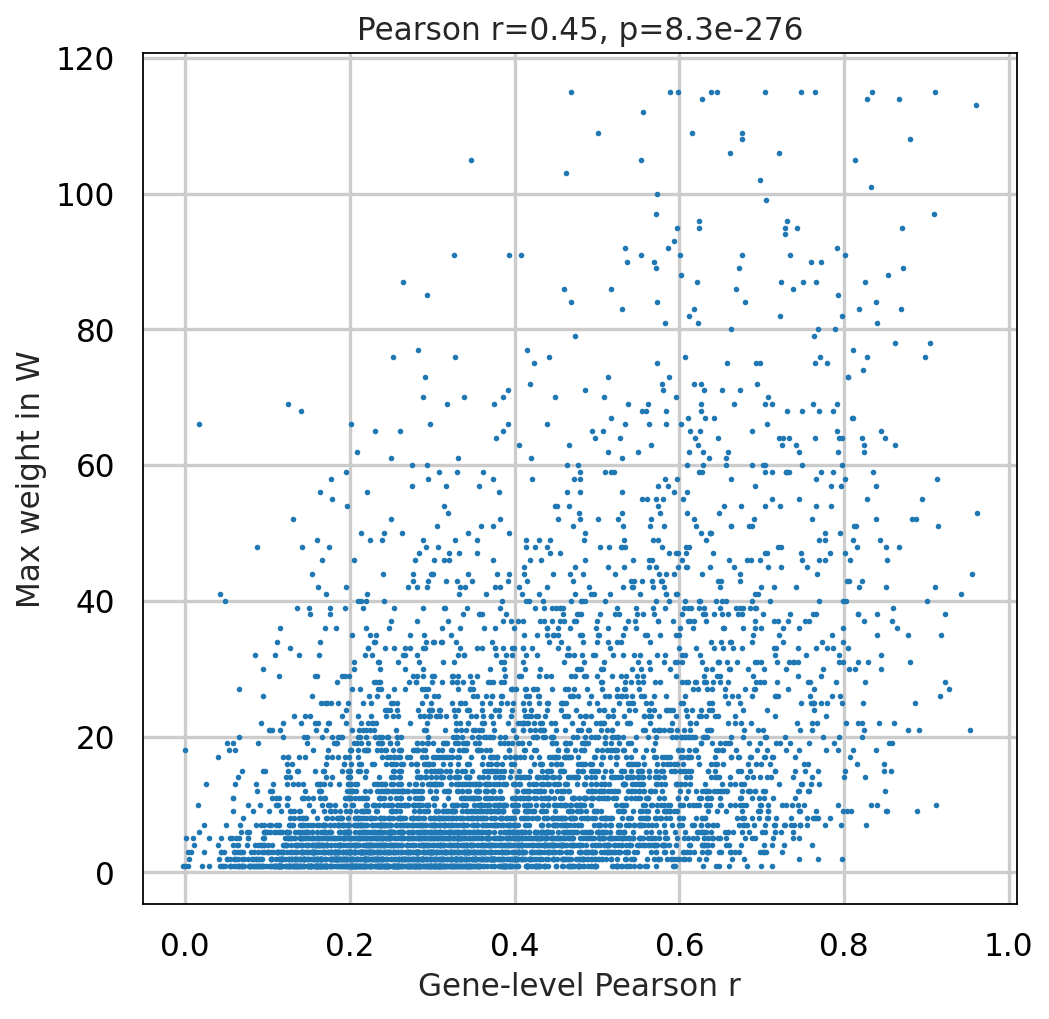

In [14]:
fig, ax = plt.subplots()
ax.scatter(corr_gene, pmat_maxw, s=1)
# r, p = stats.spearmanr(corr_gene, pmat_maxw, nan_policy='omit')
r, p = stats.pearsonr(pmat_maxw, corr_gene)
ax.set_title(f'Pearson r={r:.2f}, p={p:.2g}')
ax.set_xlabel('Gene-level Pearson r')
ax.set_ylabel('Max weight in W')
plt.show()

In [15]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

In [58]:
%%time
eta2_c1, SSt_c1, SSb_c1 = anova_eta2(y, ref_data.obs['Level_1_class_label'].values)
eta2_c2, SSt_c2, SSb_c2 = anova_eta2(y, ref_data.obs['Level_2_neighborhood_label'].values)
eta2_c3, SSt_c3, SSb_c3 = anova_eta2(y, ref_data.obs['Level_3_subclass_label'].values)
eta2_c5, SSt_c5, SSb_c5 = anova_eta2(y, ref_data.obs['Level_5_cluster_label'].values)

CPU times: user 45.7 s, sys: 1min 14s, total: 2min
Wall time: 2min


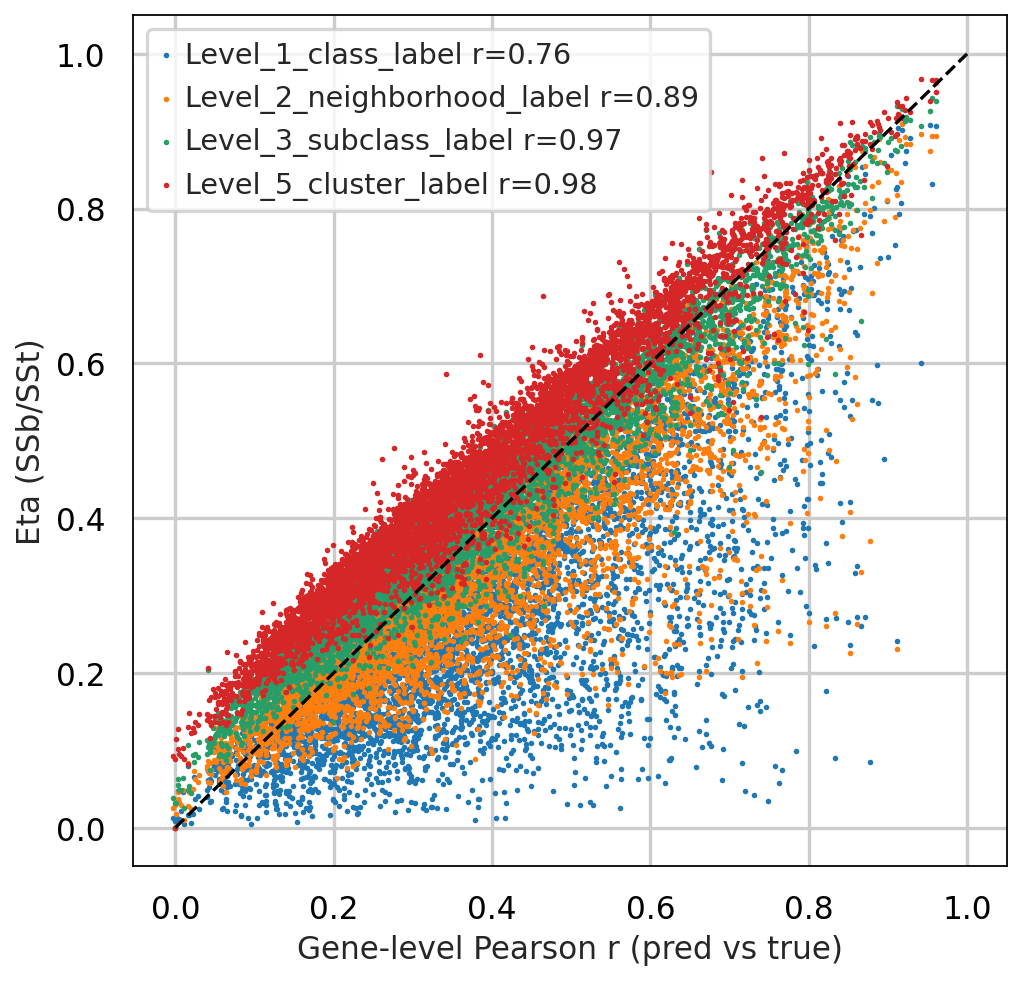

In [59]:
etas = [
    np.sqrt(eta2_c1),
    np.sqrt(eta2_c2),
    np.sqrt(eta2_c3),
    np.sqrt(eta2_c5),
]
labels = [
    'Level_1_class_label',
    'Level_2_neighborhood_label',
    'Level_3_subclass_label',
    'Level_5_cluster_label',
]


fig, ax = plt.subplots()
for eta, label in zip(etas, labels):
    cond = ~np.isnan(corr_gene)
    # r, p = stats.spearmanr(corr_gene, eta, nan_policy='omit')
    r, p = stats.pearsonr(corr_gene[cond], eta[cond])
    ax.scatter(corr_gene, eta, s=1, label=f"{label} r={r:.2f}")
    
ax.legend()
ax.plot([0,1], [0,1], '--k')
ax.set_xlabel('Gene-level Pearson r (pred vs true)')
ax.set_ylabel('Eta (SSb/SSt)')
plt.show()

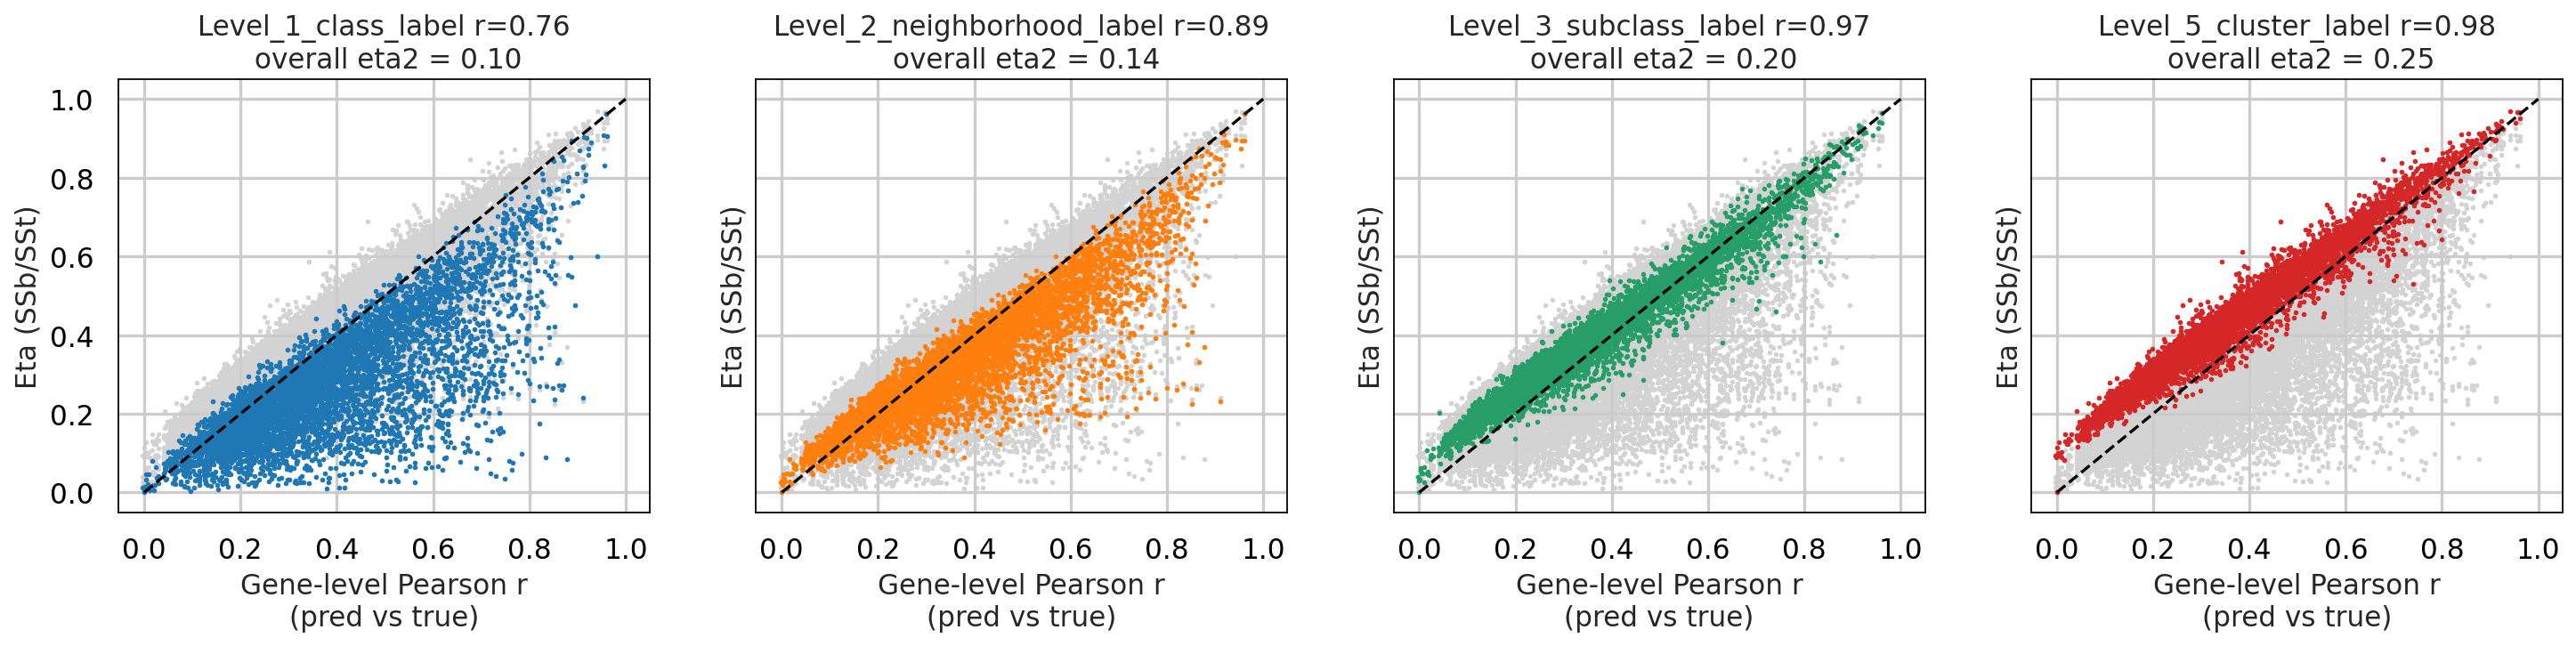

In [88]:
etas = [
    np.sqrt(eta2_c1),
    np.sqrt(eta2_c2),
    np.sqrt(eta2_c3),
    np.sqrt(eta2_c5),
]
overall_scores = [
    SSb_c1.sum()/SSt_c1.sum(),
    SSb_c2.sum()/SSt_c2.sum(),
    SSb_c3.sum()/SSt_c3.sum(),
    SSb_c5.sum()/SSt_c5.sum(),
]
labels = [
    'Level_1_class_label',
    'Level_2_neighborhood_label',
    'Level_3_subclass_label',
    'Level_5_cluster_label',
]


fig, axs = plt.subplots(1, 4, figsize=(5.5*4, 4*1), sharex=True, sharey=True)
for i, (eta, label, overall_score, ax) in enumerate(zip(etas, labels, overall_scores, axs)):
    cond = ~np.isnan(corr_gene)
    r, p = stats.pearsonr(corr_gene[cond], eta[cond])
    # r, p = stats.spearmanr(corr_gene, eta, nan_policy='omit')
    ax.scatter(corr_gene, eta, s=1, color=f'C{i}')
    
    for eta in etas:
        ax.scatter(corr_gene, eta, s=1, color='lightgray', zorder=0)
    
    # ax.legend()
    ax.plot([0,1], [0,1], '--k')
    ax.set_title(f"{label} r={r:.2f}\n overall eta2 = {overall_score:.2f}")
    ax.set_xlabel('Gene-level Pearson r\n(pred vs true)')
    ax.set_ylabel('Eta (SSb/SSt)')
fig.subplots_adjust(wspace=0.2)
plt.show()

# Linear limit

In [19]:
ndim = y.shape[1]
ndim

5576

In [79]:
%%time
cutoff = 1000
pca = PCA(n_components=cutoff)
pcy = pca.fit_transform(y) # centering is done automatically
# pcy = pca.fit_transform(y - y.mean(axis=0)) # centering is done automatically

CPU times: user 10min 8s, sys: 2min 45s, total: 12min 54s
Wall time: 1min 9s


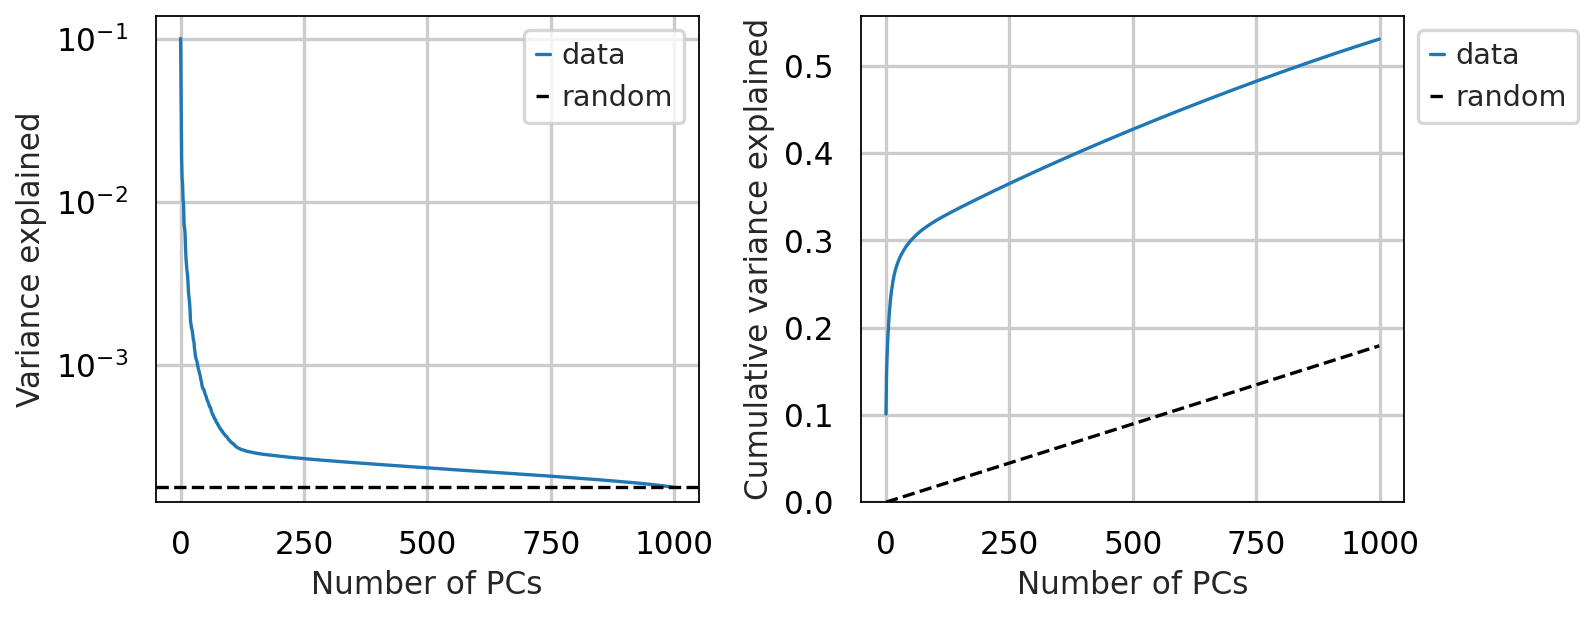

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
ax = axs[0]
ax.plot(pca.explained_variance_ratio_, label='data')
ax.axhline(1/ndim, linestyle='--', color='k', label='random')
ax.set_yscale('log')
ax.set_ylim(ymin=1/ndim*0.8)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Variance explained")

ax = axs[1]
ax.plot(np.cumsum(pca.explained_variance_ratio_), label='data')
ax.plot(np.cumsum([1/ndim]*cutoff), '--k', label='random')
ax.set_ylim(ymin=0)
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Cumulative variance explained")
ax.legend(bbox_to_anchor=(1,1))

fig.subplots_adjust(wspace=0.3)
plt.show()

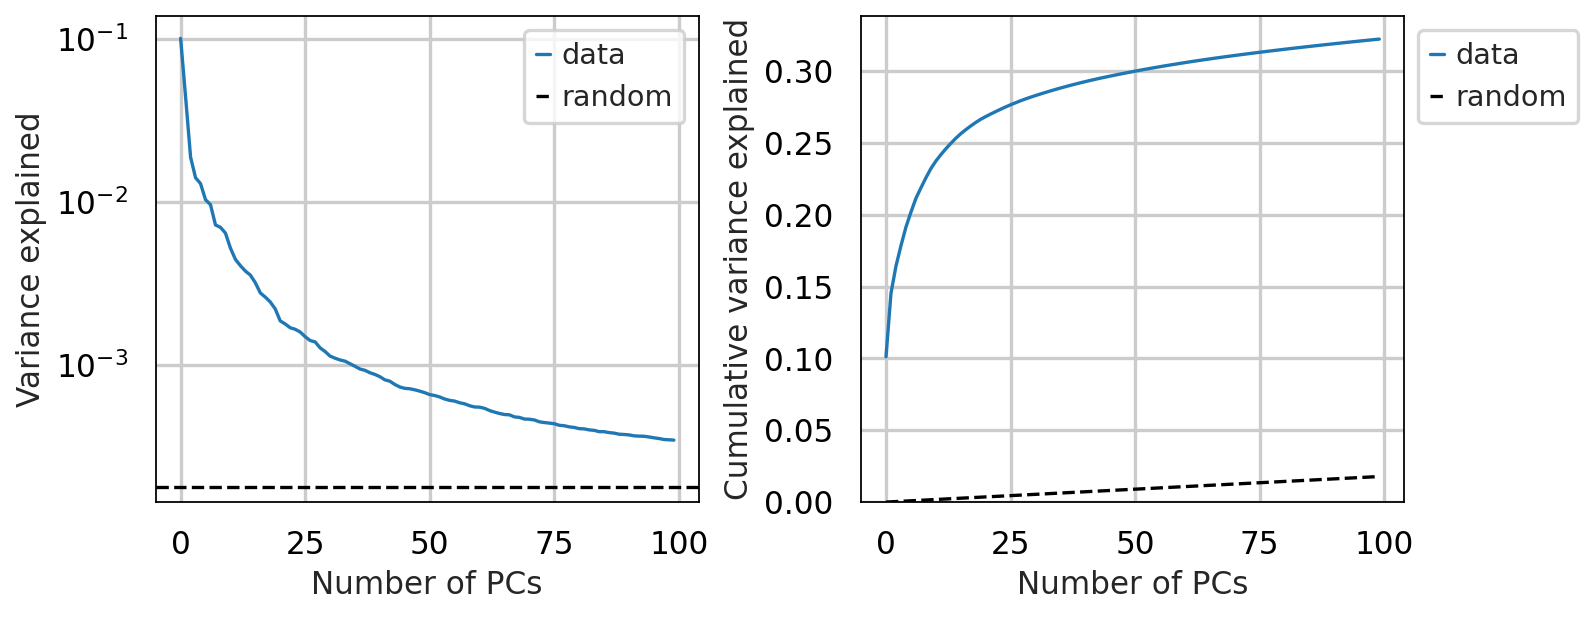

In [81]:
cutoff_viz = 100

fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
ax = axs[0]
ax.plot(pca.explained_variance_ratio_[:cutoff_viz], label='data')
ax.axhline(1/ndim, linestyle='--', color='k', label='random')
ax.set_yscale('log')
ax.set_ylim(ymin=1/ndim*0.8)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Variance explained")

ax = axs[1]
ax.plot(np.cumsum(pca.explained_variance_ratio_)[:cutoff_viz], label='data')
ax.plot(np.cumsum([1/ndim]*cutoff_viz), '--k', label='random')
ax.set_ylim(ymin=0)
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Cumulative variance explained")
ax.legend(bbox_to_anchor=(1,1))

fig.subplots_adjust(wspace=0.3)
plt.show()

In [42]:
yshuff = np.empty(y.shape)
for i in np.arange(len(y)):
    yshuff[i] = y[i][np.random.choice(ndim, size=ndim, replace=False)]
    
# yt = y.T
# yshuff = np.empty(yt.shape)
# for i in np.arange(len(yt)):
#     yshuff[i] = yt[i][np.random.choice(yt.shape[1], size=yt.shape[1], replace=False)]

In [43]:
cutoff_simu = 100
pca_shuff = PCA(n_components=cutoff_simu)
pca_shuff.fit(yshuff)

PCA(n_components=100)

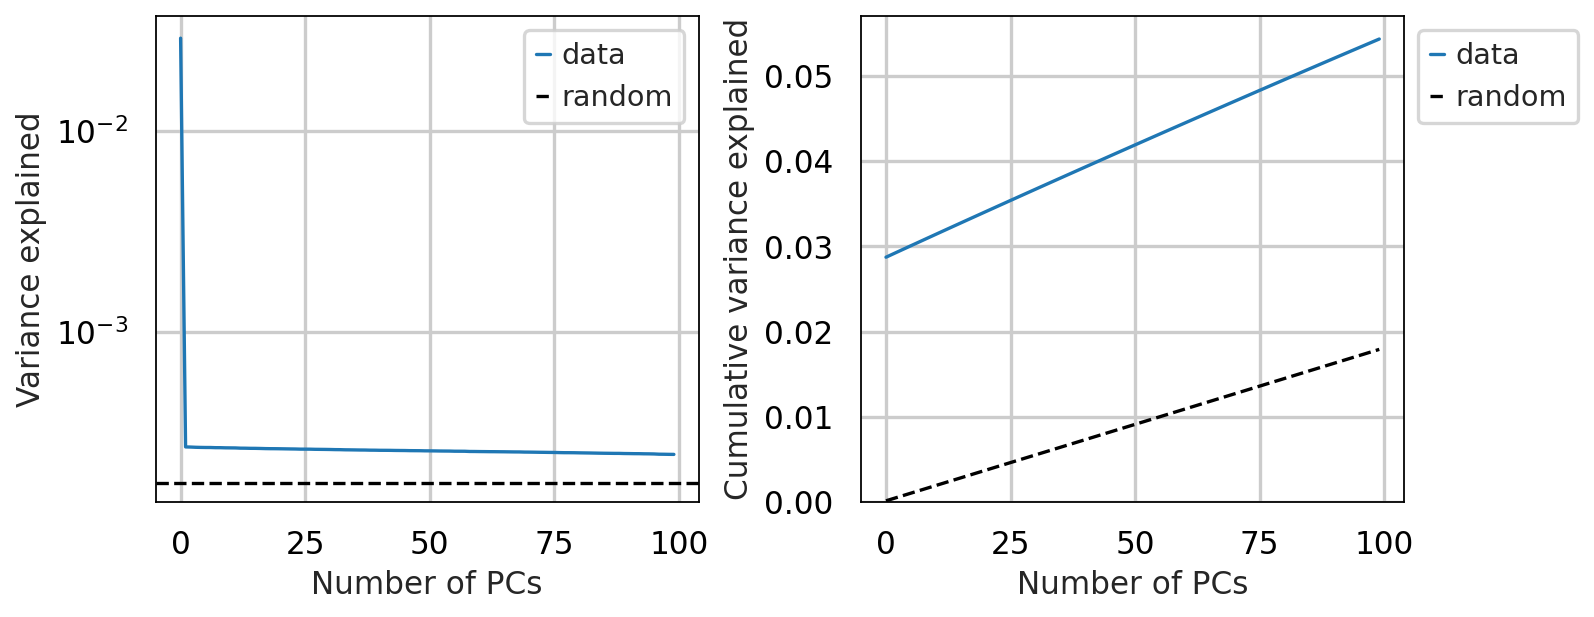

In [44]:

cutoff_viz = 100

fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
ax = axs[0]
ax.plot(pca_shuff.explained_variance_ratio_[:cutoff_viz], label='data')
ax.axhline(1/ndim, linestyle='--', color='k', label='random')
ax.set_yscale('log')
ax.set_ylim(ymin=1/ndim*0.8)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Variance explained")

ax = axs[1]
ax.plot(np.cumsum(pca_shuff.explained_variance_ratio_)[:cutoff_viz], label='data')
ax.plot(np.cumsum([1/ndim]*cutoff_viz), '--k', label='random')
ax.set_ylim(ymin=0)
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Cumulative variance explained")
ax.legend(bbox_to_anchor=(1,1))

fig.subplots_adjust(wspace=0.3)
plt.show()

In [87]:
# overall variance explained by cell types
SSb_c5.sum()/SSt_c5.sum(), SSb_c3.sum()/SSt_c3.sum(), SSb_c2.sum()/SSt_c5.sum(), SSb_c1.sum()/SSt_c1.sum()

(0.24876366662425084,
 0.20290727845419038,
 0.14220924246335384,
 0.09722172922070822)